Importation

In [1]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import layers, losses
tf.config.set_visible_devices([], 'GPU')


2023-08-08 10:56:27.290229: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-08 10:56:32.594678: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-08 10:56:32.595782: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-08 10:56:32.641481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:9e:00.0 name: Quadro P400 computeCapability: 6.1
coreClock: 1.2525GHz coreCount: 2 deviceMemorySize: 1.94GiB deviceMemoryBandwidth: 29.88GiB/s
2023-08-08 10:56:32.641537: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-08 10:56:32.713658: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-08-08 

In [2]:
#Fonction custom tf (sinus)
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from PIL import Image

def custom_activation(x):
  
    return (tf.math.sin(30*x))
     
get_custom_objects().update({'custom_activation': Activation(custom_activation)})


SAMPLING LAYER

In [17]:


"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



Définition du réseau

In [18]:

"""
## Build the encoder + DEFINIE LATENT DIMENSION
"""

latent_dim = 16

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(64, activation="relu")(x)
x         = layers.Dense(32, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(64, activation="relu")(inputs)

x       = layers.Dense(7 * 7 * 64, activation="relu")(x)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(16, 3, strides=1, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

decoder.summary()



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

Class VAE

In [19]:

"""
## Define the VAE as a `Model` with a custom `train_step`
"""
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta=beta
        

    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        output               = self.decoder(z)
        return output
                
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss":     total_loss,
            "r_loss":   reconstruction_loss,
            "kl_loss":  kl_loss,
        }
    

    def predict(self,inputs):
        '''Our predict function...'''
        z_mean, z_var, z  = self.encoder.predict(inputs)
        outputs           = self.decoder.predict(z)
        return outputs



ENTRAINEMENT et Import bdd

MNIST

In [20]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

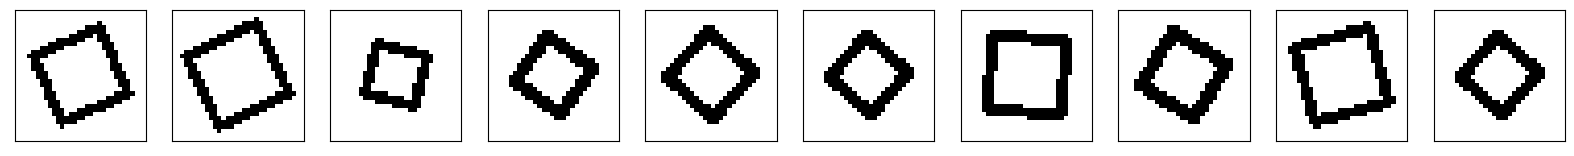

<function matplotlib.pyplot.close(fig=None)>

In [46]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(Bdd_train[i])

  
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()
plt.close

In [22]:


"""
## Train the VAE + CREATE TRAIN AND TEST SET USING A DIGIT OR MULTIPLE ONES
"""

# Define the selected digits
selected_digits = [6]

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Filter the dataset to include only the selected digits
train_mask = [label in selected_digits for label in y_train]
test_mask = [label in selected_digits for label in y_test]

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]



#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits_train = x_train[0:10000]
mnist_digits_train = np.expand_dims(mnist_digits_train, -1).astype("float32") / 255

mnist_digits_test = x_test[0:2000]
mnist_digits_test = np.expand_dims(mnist_digits_test, -1).astype("float32") / 255





epoch=400

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

train_size=len(mnist_digits_train)
batch_size=256
initial_learning_rate = 0.001
final_learning_rate = 0.000001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epoch)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule) 

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)



vae = VAE(encoder, decoder,0.)
vae.compile(optimizer=keras.optimizers.Adam(),loss=tf.keras.losses.BinaryCrossentropy())
vae.fit(mnist_digits_train,epochs=epoch, batch_size=batch_size,validation_data=(mnist_digits_test,mnist_digits_test),callbacks=[callback])



Epoch 1/400
24/24 [==============================] - 3s 111ms/step - loss: 309.1079 - r_loss: 309.1079 - kl_loss: 24.0998 - val_loss: 0.2586
Epoch 2/400
24/24 [==============================] - 2s 95ms/step - loss: 190.4069 - r_loss: 190.4069 - kl_loss: 20.1253 - val_loss: 0.2416
Epoch 3/400
24/24 [==============================] - 2s 90ms/step - loss: 180.4724 - r_loss: 180.4724 - kl_loss: 28.6563 - val_loss: 0.2332
Epoch 4/400
24/24 [==============================] - 2s 93ms/step - loss: 173.2014 - r_loss: 173.2014 - kl_loss: 54.0472 - val_loss: 0.2205
Epoch 5/400
24/24 [==============================] - 2s 89ms/step - loss: 159.7890 - r_loss: 159.7890 - kl_loss: 147.7437 - val_loss: 0.2025
Epoch 6/400
24/24 [==============================] - 2s 90ms/step - loss: 146.0383 - r_loss: 146.0383 - kl_loss: 303.7675 - val_loss: 0.1795
Epoch 7/400
24/24 [==============================] - 2s 89ms/step - loss: 131.8136 - r_loss: 131.8136 - kl_loss: 496.9982 - val_loss: 0.1659
Epoch 8/400
24/2

In [23]:
#vecteurs latents
Mnist_train_latent=vae.encoder(mnist_digits_train)[0]
Mnist_test_latent=vae.encoder(mnist_digits_train)[0]

In [24]:
mnist_digits_train.shape

(5918, 28, 28, 1)

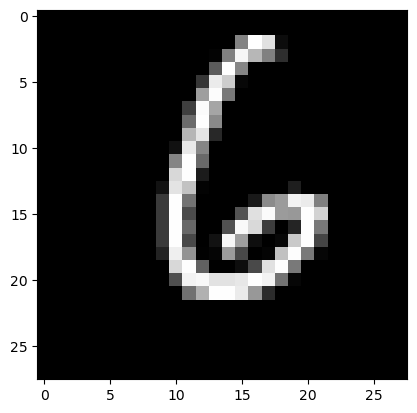

<function matplotlib.pyplot.close(fig=None)>

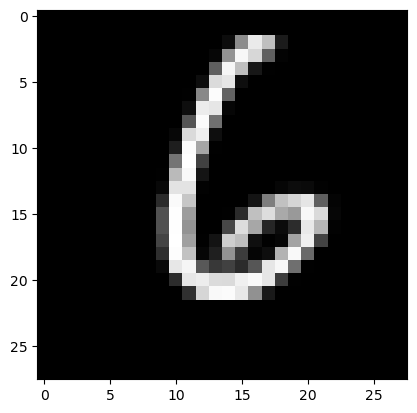

In [25]:
#Affichage pour voir si ça se reconstruit bien
X=np.array([mnist_digits_train[2]])
plt.imshow(X[0],cmap='gray')
plt.show()
plt.close
Y=vae.encoder(X)
plt.imshow(vae.decoder(Y[0])[0],cmap='gray')
plt.show
plt.close

In [31]:
np.array(Y[0])

array([[ 12.961175  ,   6.6812143 ,   9.171284  , -25.114756  ,
          7.355288  ,  19.096981  ,  -5.7955747 ,   2.970381  ,
        -11.712582  ,  53.74856   ,  21.508186  , -24.852495  ,
        -13.376559  ,  19.779005  ,   7.2028375 ,  -0.83868736]],
      dtype=float32)

Parcours espace latent

In [106]:
#Fonction qui crée n vecteurs qui parcourt le chemin d'un point A a un point B : si A=[0,0] et B=[1,2] alors si on choisit 3 points on obtient le chemin de A à B suivant [0,0] -> 
# [1/2,1] -> [1,2]

import numpy as np

def interpolate_vectors(A, B, num_points=10):

    assert A.shape == B.shape, "A and B must have the same shape"

    # Calculate the step size for interpolation
    step_size = (B - A) / (num_points + 1)

    # Generate the interpolated vectors
    interpolated_vectors = [A + i * step_size for i in range(1, num_points + 1)]

    return np.array(interpolated_vectors)

In [136]:
#Creation du point de  depart A et du point d'arrivée B puis V le vecteur avec les interpolations

X=np.array([mnist_digits_train[8]])
A=np.array(vae.encoder(X)[0])
X=np.array([mnist_digits_train[13]])
B=np.array(vae.encoder(X)[0])
V=interpolate_vectors(V[2],V[4])
V.shape

(10, 1, 16)

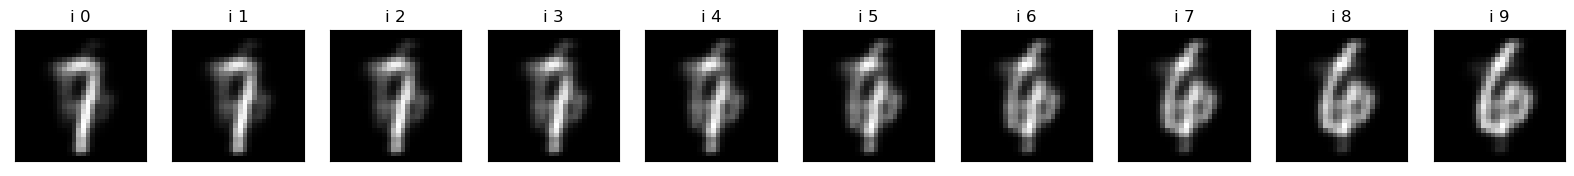

<function matplotlib.pyplot.close(fig=None)>

In [137]:
#Visualisation du chemin entre A et B : les éléments du vecteur V

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(vae.decoder(V[i])[0])

  plt.title("i "+str(i))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()
plt.close


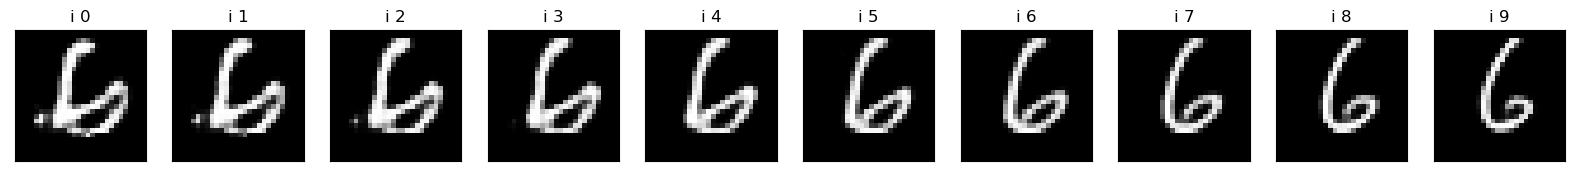

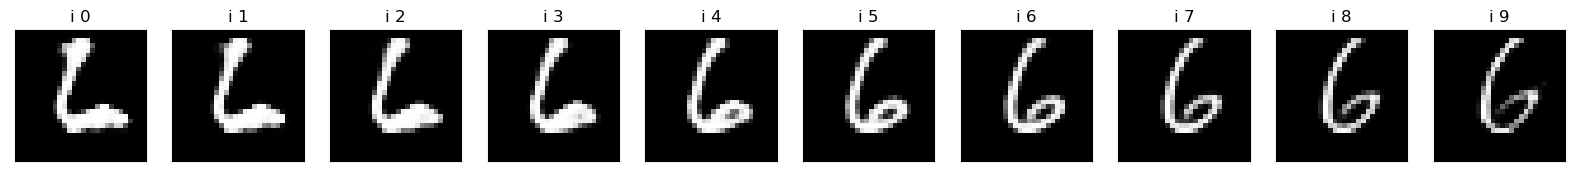

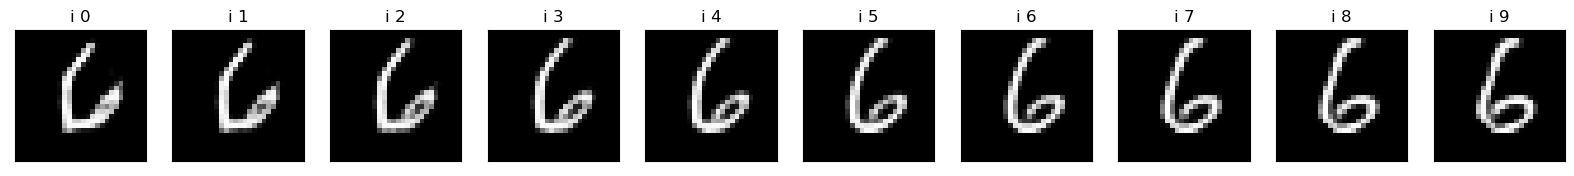

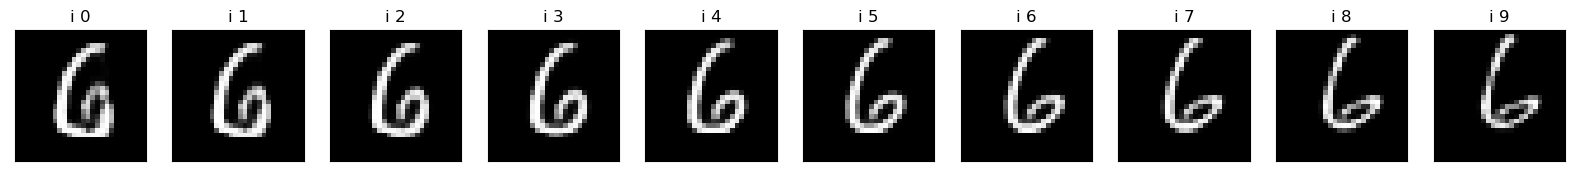

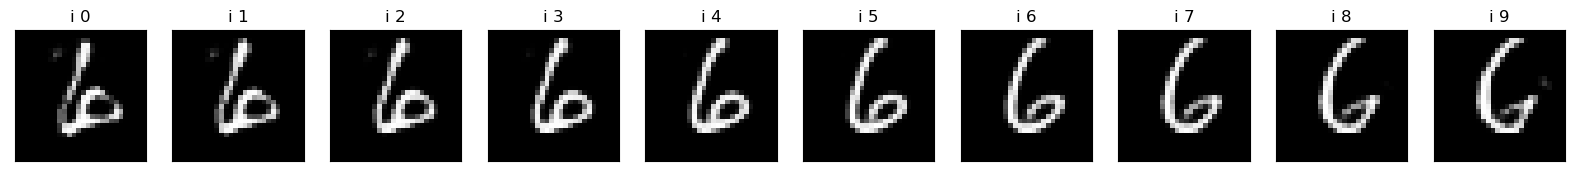

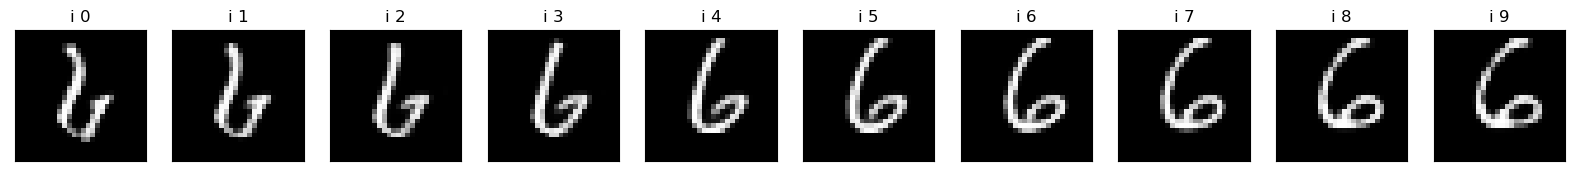

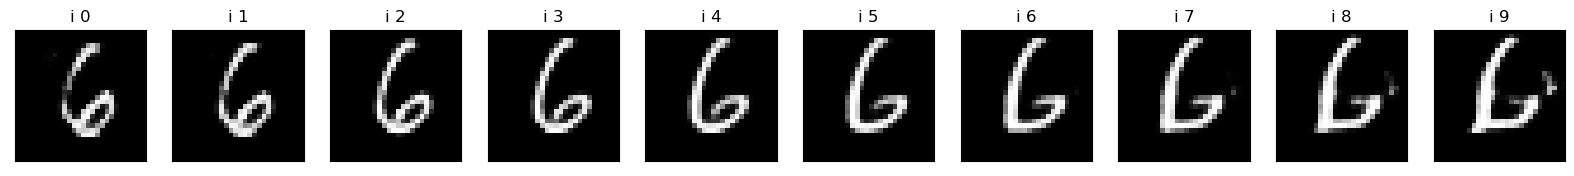

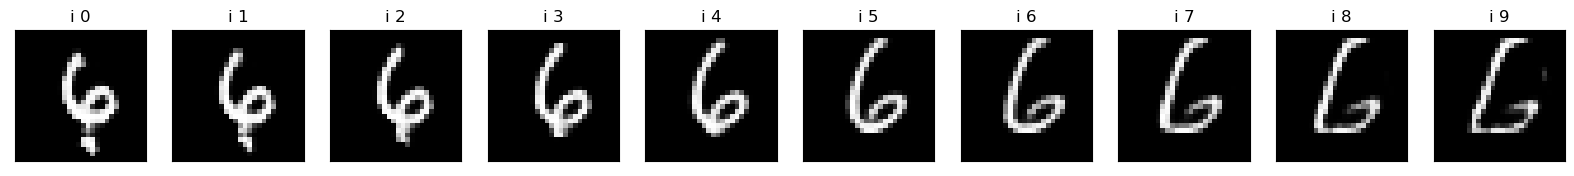

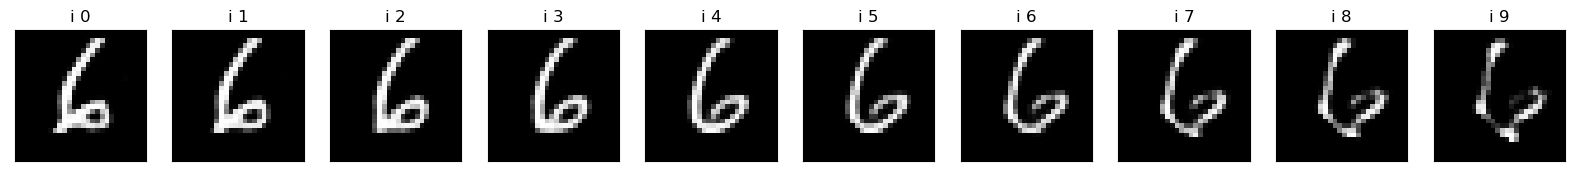

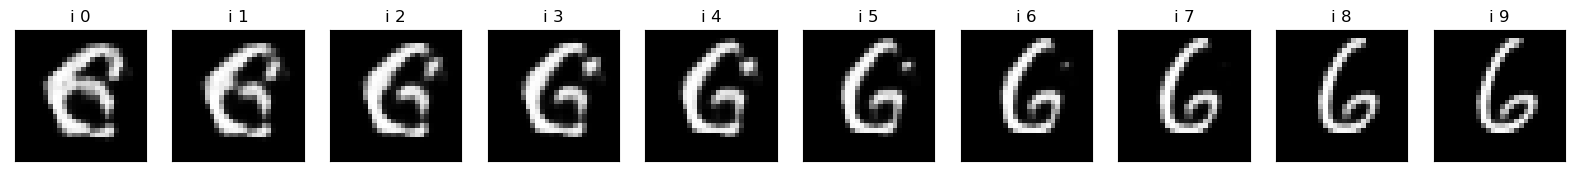

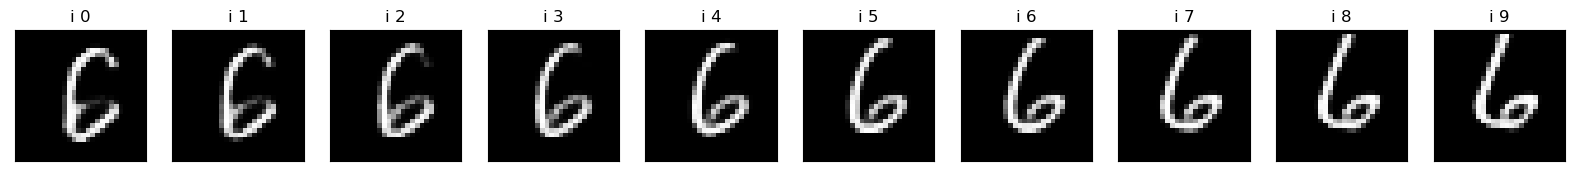

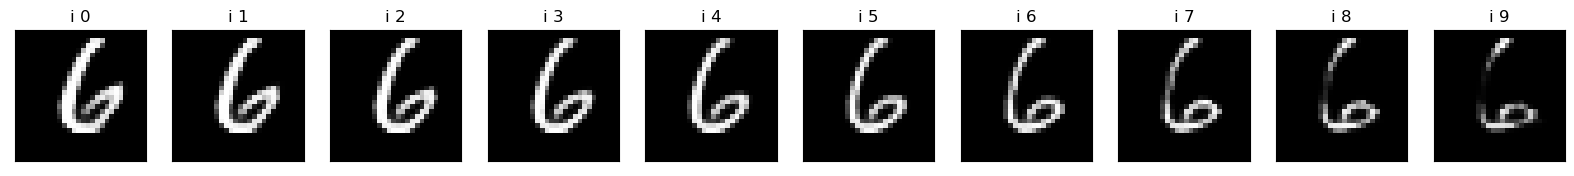

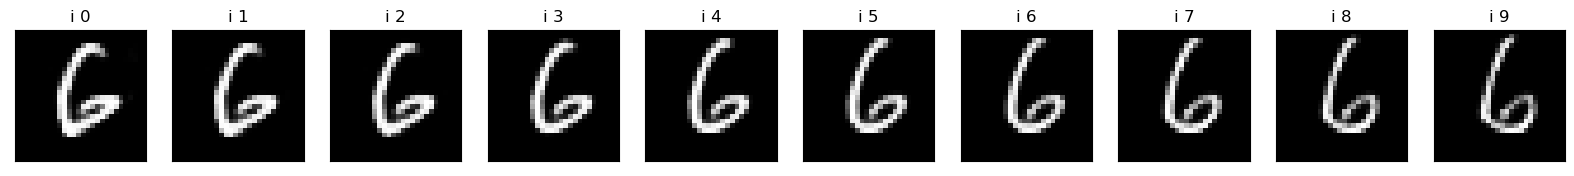

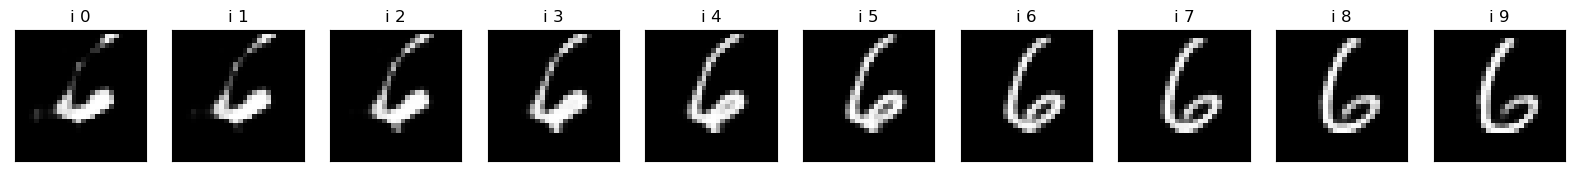

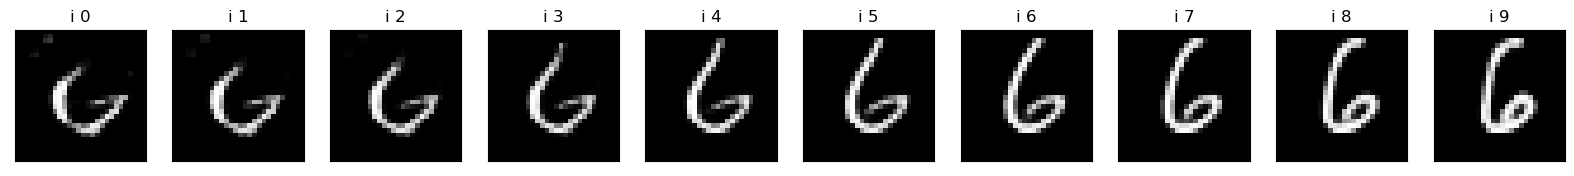

In [32]:
#À partir d'un élément de référence Y[0] on fixe toutes les variables sauf une que l'on modifie entre le min et le max sur son axe
#On affiche 10 images suivant ces variations
#Ceci est réalisé pour toutes les variables

for p in range(0,15):

 #p va de 0 a 15
  m=np.min(Mnist_train_latent,axis=0)[p]
  M=np.max(Mnist_train_latent,axis=0)[p]
  x=np.arange(m,M,(M-m)/10)
  y=np.array(Y[0])
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    y[0,p]=x[i]
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(vae.decoder(y)[0])

    plt.title("i "+str(i))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.show()
  plt.close

Levina Bickel

In [42]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k + 1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample

def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k

In [43]:
encoded_imgs = np.array(np.concatenate((Mnist_train_latent,Mnist_test_latent)))
bis=encoded_imgs.reshape(len(Mnist_test_latent)+len(Mnist_train_latent),16)
print(encoded_imgs.shape)
dim = intrinsic_dim_scale_interval(bis,k1=5,k2=100)
print(np.array(dim).mean())

(11836, 16)
7.958320667706691


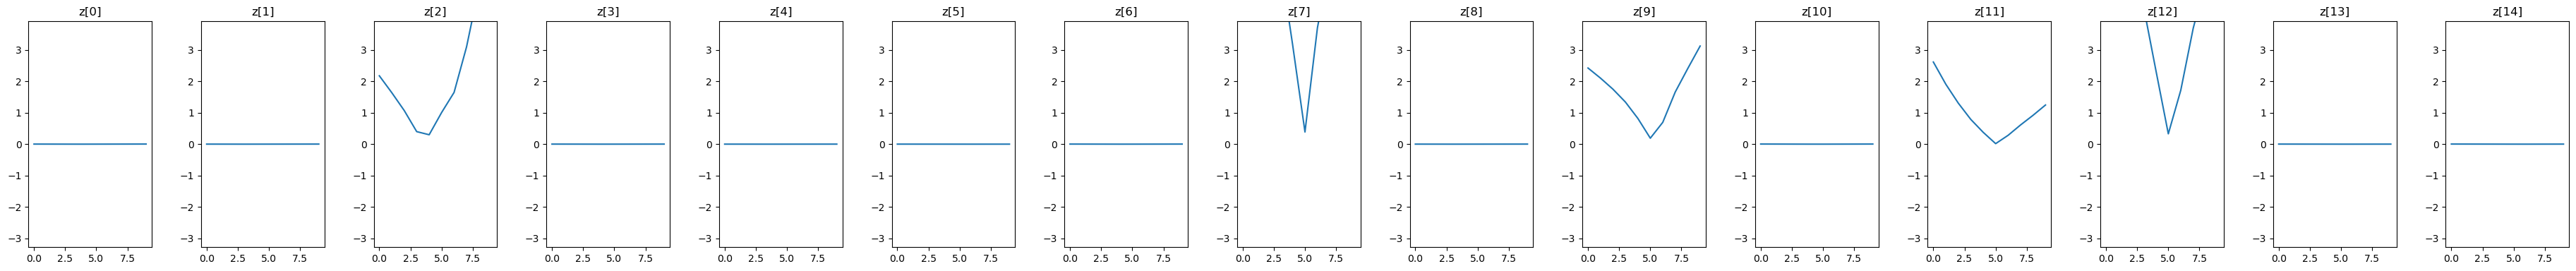

In [99]:

#Etant l'élément de reference Y, nous affichons le graphe de la norme de la differnce entre Y et l'élément qu'on explore
#Le graphe montre la variation de cette valeur par axe
#NOus avons donc 16 graphes
fig, axes = plt.subplots(1, 15, figsize=(40, 4))  # Increase the figsize to make the figures bigger

for p in range(0, 15):
    z = []
    m = np.min(Mnist_train_latent, axis=0)[p]
    M = np.max(Mnist_train_latent, axis=0)[p]
    x = np.arange(m, M, (M - m) / 10)
    ref = np.array([[0. for i in range(16)]])
    y = np.array([[0. for i in range(16)]])
    n = 10
    
    for i in range(n):
        y[0, p] = x[i]
        refhat = vae.decoder(ref)[0]
        yhat = vae.decoder(y)[0]
        z.append(np.linalg.norm(refhat - yhat))
    
    ax = axes[p]  # Select the corresponding subplot
    ax.plot(z)
    ax.set_ylim(np.min(Mnist_train_latent),np.max(Mnist_train_latent))
    ax.set_title("z[" + str(p) + "]")

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.4)  # Adjust the spacing between subplots
plt.show()


BDD GEOMETRIES : Carres

In [6]:
#Convertisseur de rgb a gris
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [45]:
#Importation image généré au prealable

nom_fichier="carre"
n=2000
indice_train=int(n*0.8)
size=128
Bdd_train=[]
Bdd_test=[]



for i in range(0,indice_train):
    image1=plt.imread("../Datasets/Geometrie/"+nom_fichier+"s/"+nom_fichier+"_"+str(i)+".png")
    Bdd_train.append(image1)
    
    

print("train fait")
  
k=0

for i in range(indice_train,n):
    image1=plt.imread("../Datasets/Geometrie/"+nom_fichier+"s/"+nom_fichier+"_"+str(i)+".png")
    Bdd_test.append(image1)

         
print("test fait")     
k=0
Bdd_train=np.expand_dims(Bdd_train, -1)
Bdd_test=np.expand_dims(Bdd_test, -1)

train fait
test fait


In [151]:
#redéfintion de l'auto encodeur

latent_dim = 6

inputs    = keras.Input(shape=(64, 64, 1))
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(64, activation="relu")(x)
x         = layers.Dense(32, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(64, activation="relu")(inputs)
x       = layers.Dense(4 * 4 * 64, activation="relu")(x)
x       = layers.Reshape((4, 4, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

decoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 32)   320         input_35[0][0]                   
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 16, 16, 32)   9248        conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 8, 8, 32)     9248        conv2d_43[0][0]                  
____________________________________________________________________________________________

In [156]:

vae3 = VAE(encoder, decoder,15)

epoch=200

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

train_size=len(Bdd_train)
batch_size=128
initial_learning_rate = 0.001
final_learning_rate = 0.000001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epoch)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)  



vae3.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy())
#vae3.compile(optimizer=keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())





callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
vae3.fit(Bdd_train,epochs=epoch, batch_size=batch_size,validation_data=(Bdd_test,Bdd_test),callbacks=[callback,])

Epoch 1/200
13/13 [==============================] - 3s 141ms/step - loss: 507.3223 - r_loss: 380.7981 - kl_loss: 8.4349 - val_loss: 0.0662
Epoch 2/200
13/13 [==============================] - 2s 123ms/step - loss: 332.8330 - r_loss: 204.3228 - kl_loss: 8.5673 - val_loss: 0.0416
Epoch 3/200
13/13 [==============================] - 2s 120ms/step - loss: 300.4038 - r_loss: 166.1450 - kl_loss: 8.9506 - val_loss: 0.0388
Epoch 4/200
13/13 [==============================] - 2s 118ms/step - loss: 284.8299 - r_loss: 146.1334 - kl_loss: 9.2464 - val_loss: 0.0336
Epoch 5/200
13/13 [==============================] - 2s 118ms/step - loss: 277.7043 - r_loss: 140.1638 - kl_loss: 9.1694 - val_loss: 0.0329
Epoch 6/200
13/13 [==============================] - 2s 117ms/step - loss: 273.7833 - r_loss: 133.6491 - kl_loss: 9.3423 - val_loss: 0.0326
Epoch 7/200
13/13 [==============================] - 2s 116ms/step - loss: 272.6949 - r_loss: 131.3788 - kl_loss: 9.4211 - val_loss: 0.0327
Epoch 8/200
13/13 [=

In [157]:
Mnist_train_latent=vae3.encoder(Bdd_train)[0]
Mnist_test_latent=vae3.encoder(Bdd_test)[0]

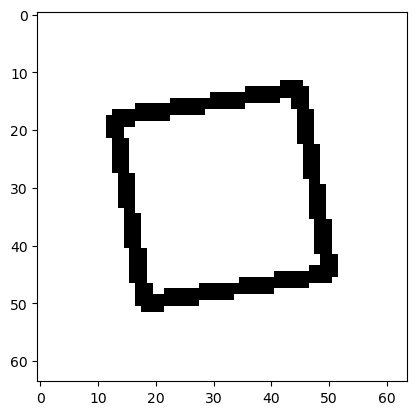

<function matplotlib.pyplot.close(fig=None)>

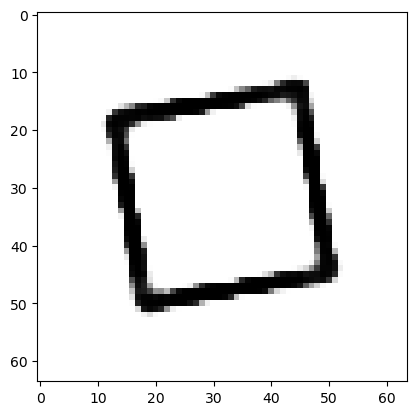

In [158]:
#Visualisation des reconstructions
X=np.array([Bdd_train[0]])
plt.imshow(X[0],cmap='gray')
plt.show()
plt.close
Y=vae3.encoder(X)
plt.imshow(vae3.decoder(Y[0])[0],cmap='gray')
plt.show
plt.close

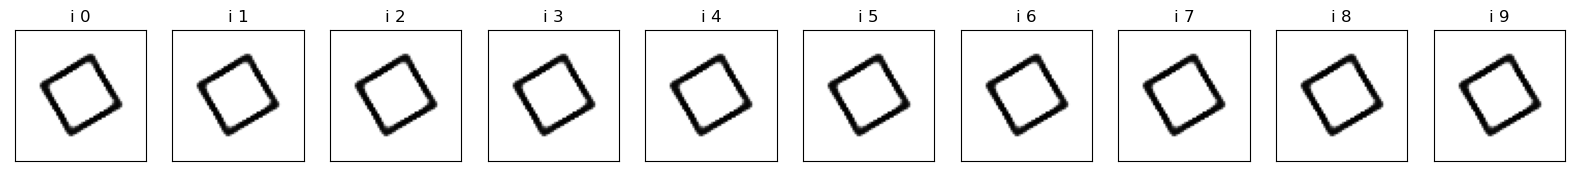

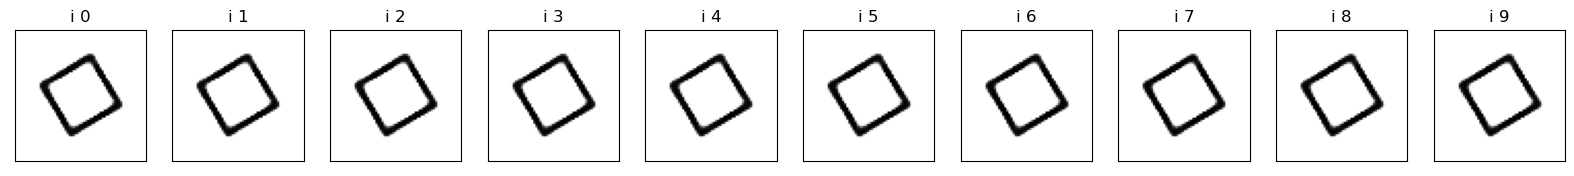

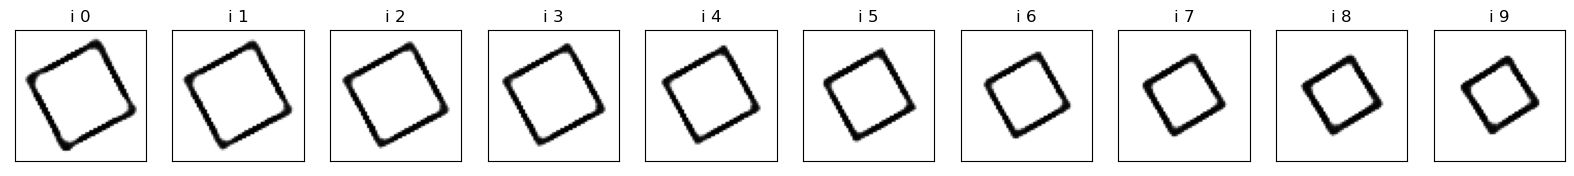

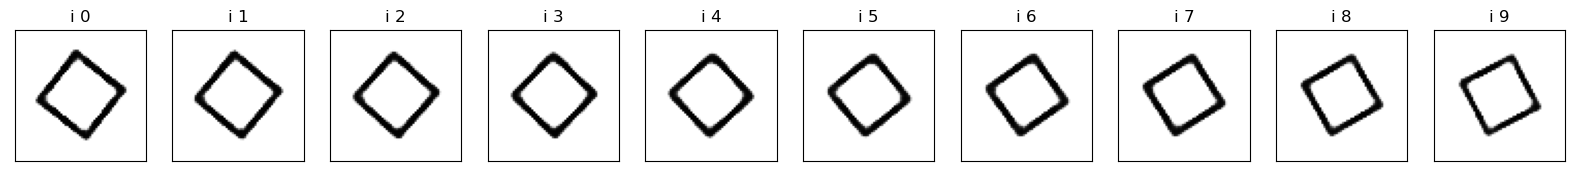

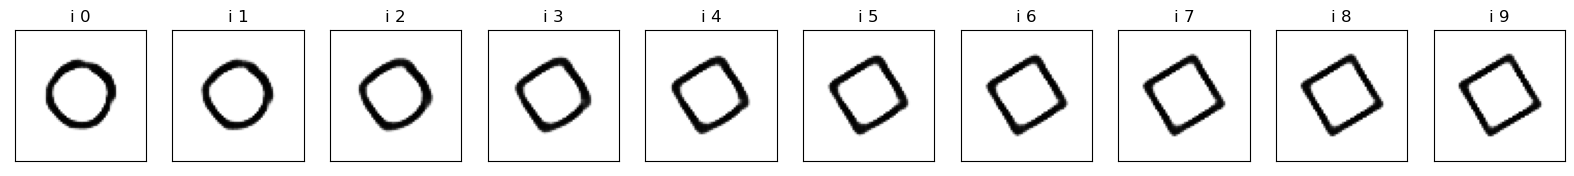

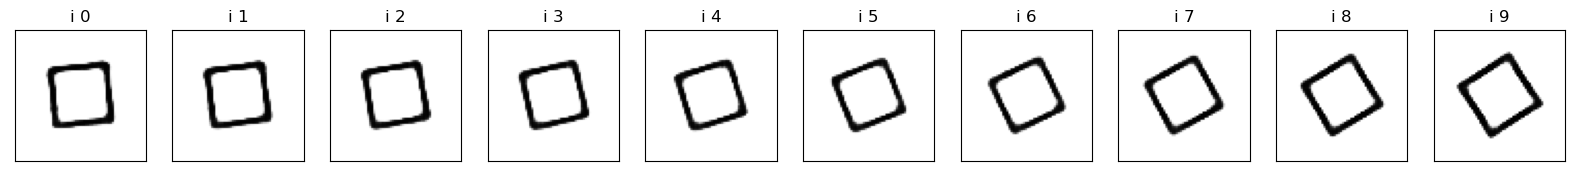

In [167]:

#COmme précédemment, on visualise les variables en se baladant dans leurs axes
for p in range(0,latent_dim):

 #p va de 0 a 15
  m=np.min(Mnist_train_latent,axis=0)[p]
  M=np.max(Mnist_train_latent,axis=0)[p]
  x=np.arange(m,M,(M-m)/10)
  y=np.array([[1. for i in range(latent_dim)]])
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    y[0,p]=x[i]
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(vae3.decoder(y)[0])

    plt.title("i "+str(i))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.show()
  plt.close

In [173]:
y0=np.array([[-1. for i in range(latent_dim)]])
y1=np.array([[1. for i in range(latent_dim)]])


In [176]:

V=interpolate_vectors(V[4],V[7])
V.shape

(10, 1, 6)

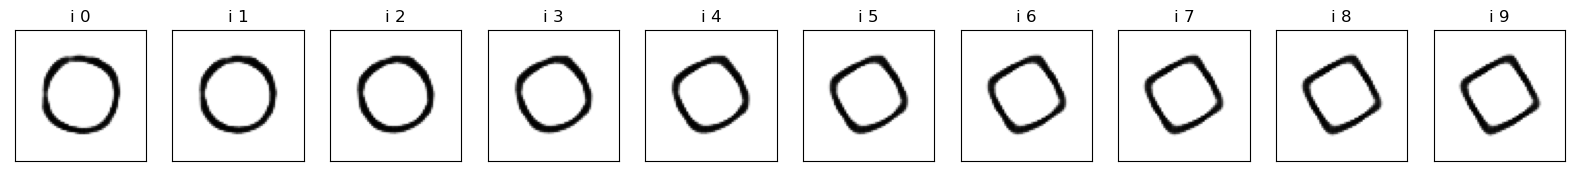

<function matplotlib.pyplot.close(fig=None)>

In [177]:
#Visualisation des modifications au cours du parcours d'un element A à un élément B (plus haut)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(vae3.decoder(V[i])[0])

  plt.title("i "+str(i))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()
plt.close


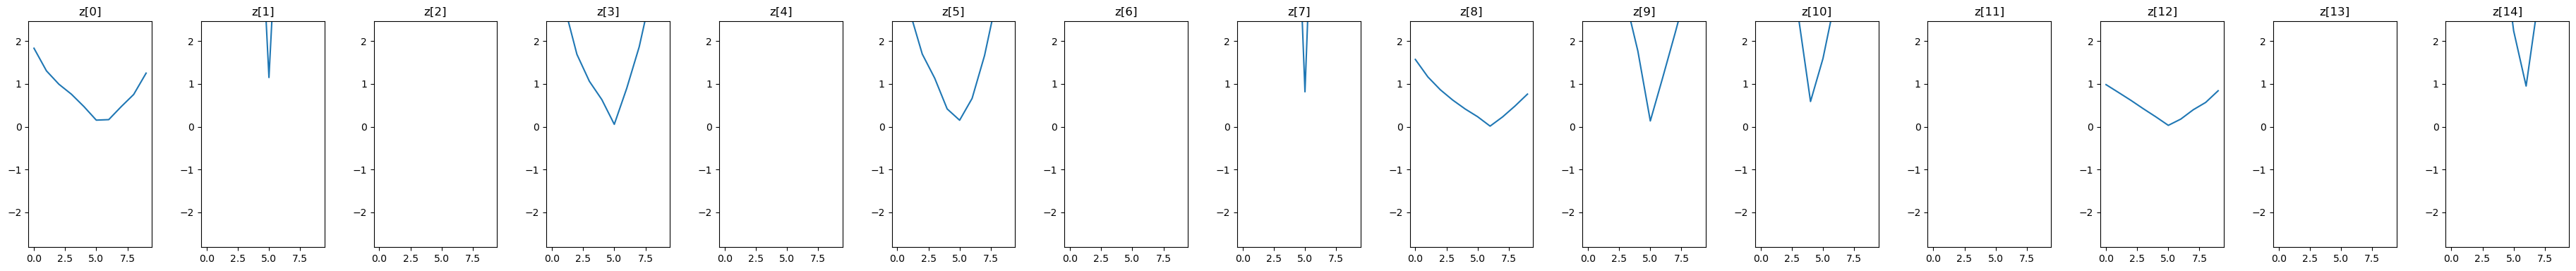

In [146]:
#Graphs des variations par axe
fig, axes = plt.subplots(1, 15, figsize=(40, 4))  # Increase the figsize to make the figures bigger

for p in range(0, 15):
    z = []
    m = np.min(Mnist_train_latent, axis=0)[p]
    M = np.max(Mnist_train_latent, axis=0)[p]
    x = np.arange(m, M, (M - m) / 10)
    ref = np.array([[0. for i in range(16)]])
    y = np.array([[0. for i in range(16)]])
    n = 10
    
    for i in range(n):
        y[0, p] = x[i]
        refhat = vae3.decoder(ref)[0]
        yhat = vae3.decoder(y)[0]
        z.append(np.linalg.norm(refhat - yhat))
    
    ax = axes[p]  # Select the corresponding subplot
    ax.plot(z)
    ax.set_ylim(np.min(Mnist_train_latent),np.max(Mnist_train_latent))
    ax.set_title("z[" + str(p) + "]")

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.4)  # Adjust the spacing between subplots
plt.show()

Disentanglement pour CIRCULAR MOTION (non réussi)

In [7]:
#Importation

nom_fichier="circular_motion"
n=3000
size=128
Bdd_train=[]
Bdd_test=[]

k=0
Nombre_images_voulues=5000
Nombre_fichiers=int(n/57)
indice_train=int(Nombre_fichiers*0.8)
indice_test=n


for i in range(0,indice_train):
    folder=i
    image1=plt.imread("../Datasets/"+nom_fichier+"/"+str(folder)+"/"+str(0)+".png")
    Bdd_train.append(rgb2gray(image1))
    
    
    for j in range(1,60):
        image1=plt.imread("../Datasets/"+nom_fichier+"/"+str(folder)+"/"+str(j)+".png")
        Bdd_train.append(rgb2gray(image1))

print("train fait")
  
k=0

for i in range(indice_train,Nombre_fichiers):
    folder=i
    image1=plt.imread("../Datasets/"+nom_fichier+"/"+str(folder)+"/"+str(0)+".png")
    Bdd_test.append(rgb2gray(image1))
    
    
    for j in range(1,60):
        image1=plt.imread("../Datasets/"+nom_fichier+"/"+str(folder)+"/"+str(j)+".png")
        Bdd_test.append(rgb2gray(image1))
         
print("test fait")     
k=0

train fait
test fait


In [8]:
Bdd_train=np.expand_dims(Bdd_train, -1)
Bdd_test=np.expand_dims(Bdd_test, -1)

In [9]:
Bdd_train=np.ceil(Bdd_train-np.min(Bdd_train))
Bdd_test=np.ceil(Bdd_test-np.min(Bdd_test))

In [10]:
Bdd_test.shape

(660, 128, 128, 1)

In [11]:
print(Bdd_train[0].shape)

(128, 128, 1)


In [35]:
loss_fn = tf.keras.losses.MeanSquaredError()

In [37]:
#définition de l'auto-encodeur

class VAE2(keras.Model):
    def __init__(self, encoder, decoder, beta,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta=beta
        

    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        output               = self.decoder(z)
        return output
                
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self(data,training=True)
            input32       = tf.cast(data,dtype=tf.float32)
            reconstruction_loss  = loss_fn(data,reconstruction)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss":     total_loss,
            "r_loss":   reconstruction_loss,
            "kl_loss":  kl_loss,
        }
    

    def predict(self,inputs):
        '''Our predict function...'''
        z_mean, z_var, z  = self.encoder.predict(inputs)
        outputs           = self.decoder.predict(z)
        return outputs




In [12]:
## Build the encoder
latent_dim = 16

inputs    = keras.Input(shape=(128, 128, 1))
x         = layers.Conv2D(4, 3, strides=2, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(8, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)



z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(1 * 1* 64, activation="relu")(inputs)
x       = layers.Reshape((1, 1, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(4, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

decoder.summary()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-07-26 09:22:40.541047: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 09:22:40.544104: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-26 09:22:40.544141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-07-26 09:22:40.544149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 8)    296         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 16)   1168        conv2d_1[0][0]                   
____________________________________________________________________________________________

In [13]:

latent_dim = 6

inputs    = keras.Input(shape=(128, 128, 1))
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(64, activation="relu")(x)
x         = layers.Dense(32, activation="relu")(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(64, activation="relu")(inputs)
x         = layers.Dense(256, activation="relu")(x)
x       = layers.Dense(16 * 16 * 64, activation="relu")(x)
x       = layers.Reshape((16, 16, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

decoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_8[0][0]                   
____________________________________________________________________________________________

In [14]:

vae2 = VAE(encoder, decoder,10)

epoch=200

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

train_size=len(Bdd_train)
batch_size=128
initial_learning_rate = 0.001
final_learning_rate = 0.000001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epoch)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)  



vae2.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy())
#vae2.compile(optimizer=keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())





callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
vae2.fit(Bdd_train,epochs=epoch, batch_size=batch_size,validation_data=(Bdd_test,Bdd_test),callbacks=[callback,])

2023-07-26 09:23:09.469228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-26 09:23:09.487023: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Epoch 1/200
20/20 [==============================] - 14s 630ms/step - loss: 5528.9927 - r_loss: 4767.1762 - kl_loss: 76.1816 - val_loss: 0.0777
Epoch 2/200
20/20 [==============================] - 12s 603ms/step - loss: 1112.1721 - r_loss: 1111.4857 - kl_loss: 0.0686 - val_loss: 0.0627
Epoch 3/200
20/20 [==============================] - 12s 604ms/step - loss: 996.5998 - r_loss: 995.6590 - kl_loss: 0.0941 - val_loss: 0.0597
Epoch 4/200
20/20 [==============================] - 12s 596ms/step - loss: 970.9926 - r_loss: 969.6808 - kl_loss: 0.1312 - val_loss: 0.0591
Epoch 5/200
20/20 [==============================] - 12s 602ms/step - loss: 956.1008 - r_loss: 955.0783 - kl_loss: 0.1022 - val_loss: 0.0583
Epoch 6/200
20/20 [==============================] - 12s 591ms/step - loss: 954.0991 - r_loss: 952.8201 - kl_loss: 0.1279 - val_loss: 0.0578
Epoch 7/200
20/20 [==============================] - 12s 589ms/step - loss: 946.1795 - r_loss: 944.5209 - kl_loss: 0.1659 - val_loss: 0.0572
Epoch 8/

In [15]:
Mnist_train_latent=vae2.encoder(Bdd_train)[0]
Mnist_test_latent=vae2.encoder(Bdd_test)[0]

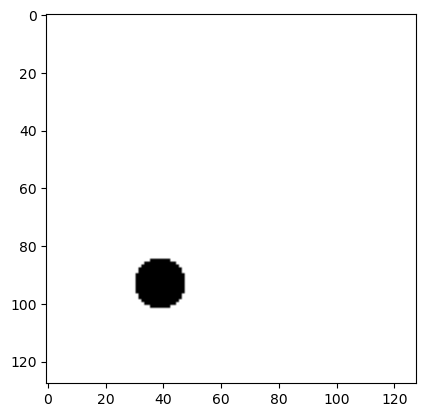

<function matplotlib.pyplot.close(fig=None)>

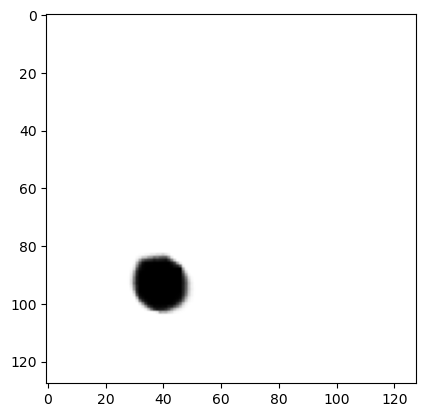

In [16]:
#visualisation de la qualité de la construction
X=np.array([Bdd_train[2]])
plt.imshow(X[0],cmap='gray')
plt.show()
plt.close
Y=vae2.encoder(X)
plt.imshow(vae2.decoder(Y[0])[0],cmap='gray')
plt.show
plt.close

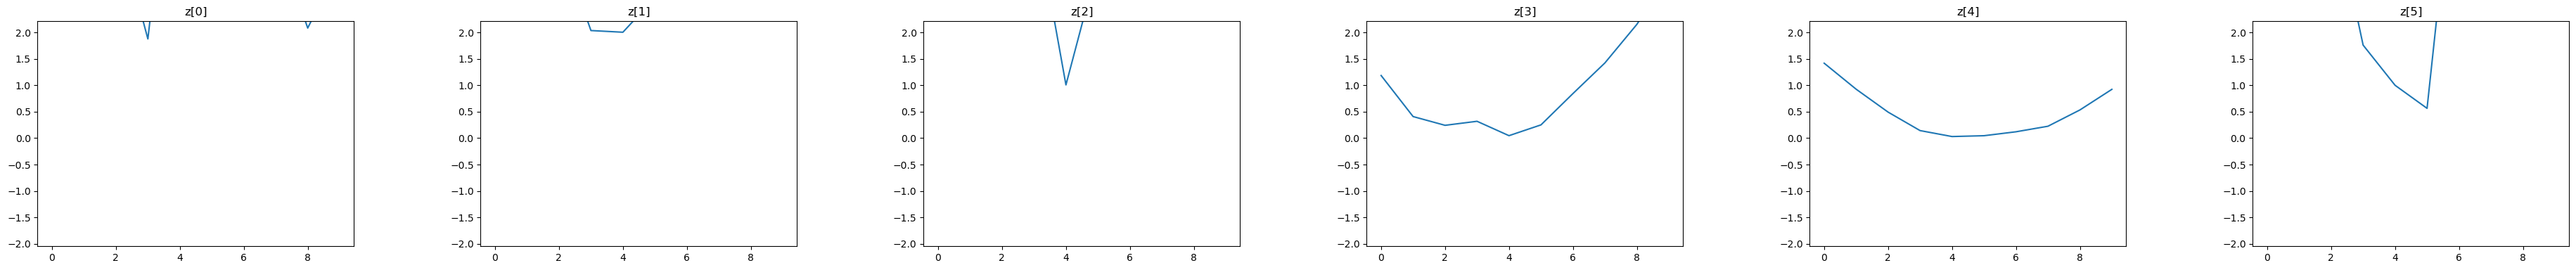

In [18]:
#Graph des variations par axe
fig, axes = plt.subplots(1, latent_dim, figsize=(40, 4))  # Increase the figsize to make the figures bigger

for p in range(0, latent_dim):
    z = []
    m = np.min(Mnist_train_latent, axis=0)[p]
    M = np.max(Mnist_train_latent, axis=0)[p]
    x = np.arange(m, M, (M - m) / 10)
    ref = np.array([[0. for i in range(latent_dim)]])
    y = np.array([[0. for i in range(latent_dim)]])
    n = 10
    
    for i in range(n):
        y[0, p] = x[i]
        refhat = vae2.decoder(ref)[0]
        yhat = vae2.decoder(y)[0]
        z.append(np.linalg.norm(refhat - yhat))
    
    ax = axes[p]  # Select the corresponding subplot
    ax.plot(z)
    ax.set_ylim(np.min(Mnist_train_latent),np.max(Mnist_train_latent))
    ax.set_title("z[" + str(p) + "]")

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.4)  # Adjust the spacing between subplots
plt.show()
    


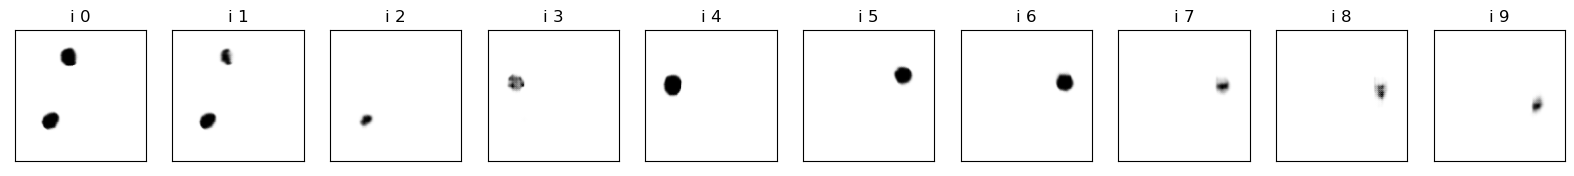

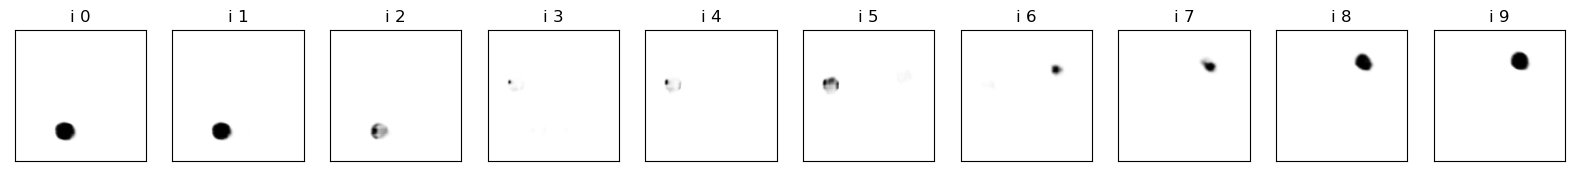

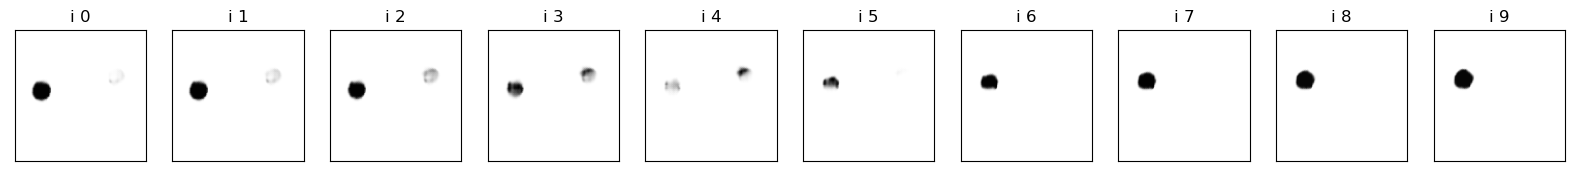

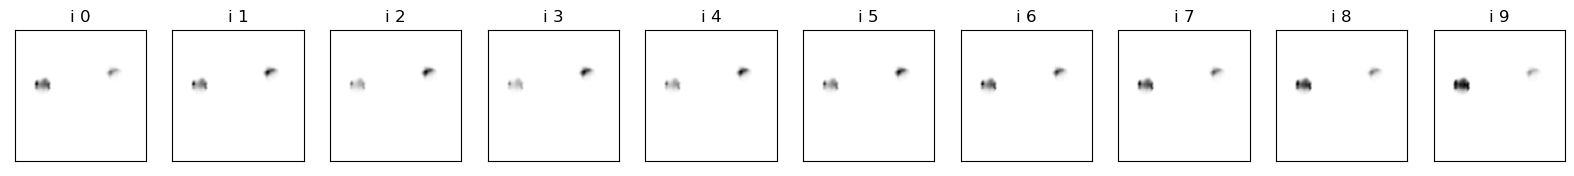

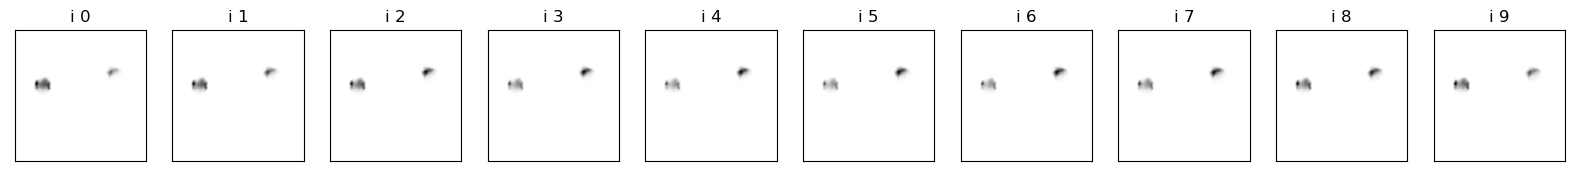

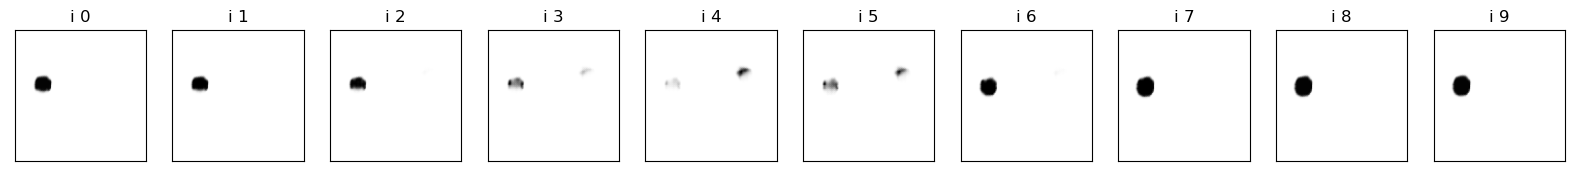

In [19]:
#Visualisation des variations par axe

for p in range(0,latent_dim):

 #p va de 0 a 15
  m=np.min(Mnist_train_latent,axis=0)[p]
  M=np.max(Mnist_train_latent,axis=0)[p]
  x=np.arange(m,M,(M-m)/10)
  y=np.array([[0. for i in range(latent_dim)]])
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    y[0,p]=x[i]
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(vae2.decoder(y)[0])

    plt.title("i "+str(i))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.show()
  plt.close